# Plot Figure 2

This notebook includes plotting for:

* Figure 2A: ZBTB16 expression for validation cohort
* Figures 2B 2C, 2E, 2F: Boxplots of bulk RNA-seq cohort scores
* Figure 2D: Survival analysis for COG cohort

The following code was executed using an R kernel in Jupyterhub, but could be copied over to an R script instead.

In [2]:
##### ----- Load libraries
requiredPackages <- c("tidyverse","Matrix","edgeR" ,"cowplot", "ggplot2", "ggbeeswarm", "survminer","survival", "plyr", "ggalt") 

for (pkg in requiredPackages){
  suppressWarnings(suppressMessages(library(pkg, character.only = T)))
}


##### ----- Directories
save_dir = "/lustre/scratch126/casm/team274sb/hw12/T_ALL/data/"

##### ----- Colours
mrd_cols <- setNames(c("#E78636", "#3C70B3", "#5AA5D6", "#ACD7ED"),
                    c('>5','0','0-1','1-5'))

if_cols <- setNames(c("#3C70B3","#E78636"), c("Responsive","IF"))

In [2]:
##### ----- Plotting function

getPval <- function(dat_p, group_str, x_vec, y_vec, val_to_test, sig_x=4){
    X <- dat_p[(dat_p[[group_str]] %in% x_vec), ][[val_to_test]]
    Y <- dat_p[(dat_p[[group_str]] %in% y_vec), ][[val_to_test]]
    X <- X[!(is.na(X))]
    Y <- Y[!(is.na(Y))]
    p_val_x <- signif(wilcox.test(X,Y,alternative="greater")$p.value,sig_x)
    return(p_val_x)
}


plot_boxes_swarm_fill <- function(dat_x, x_str, x_name, units_name, col_dict,cex_x=0.7, alpha_x=0.6, size_x=3){
    
    dat_x$x_axis <- dat_x[[x_str]]
    
    tab_x <- table(dat_x$x_axis)
    
    gg_1 <- ggplot(data=dat_x, aes(x=reorder(x_axis, Module_score_up), y=Module_score_up, fill=x_axis))+
        stat_boxplot(geom = "errorbar", width = 0.2,linewidth=0.7,aes(fill=x_axis))+
        geom_boxplot(outlier.shape = NA,linewidth=0.7,aes(fill=x_axis))+
        geom_beeswarm(data=dat_x,colour="black",cex = cex_x,alpha=alpha_x,dodge.width=0.2, size=size_x)+ #geom_beeswarm
        theme_bw()+labs(x=x_name, y="Module Score", fill="", colour="")+ 
        scale_fill_manual(values=col_dict)+scale_colour_manual(values=col_dict)+
        theme(axis.title.y=element_text(size=16, margin=margin(0,5,0,0)),
              axis.title.x=element_text(size=15, margin=margin(10,0,0,0)), 
              axis.text.y=element_text(size=12),axis.text.x=element_text(size=14), #, angle=90, hjust=1, vjust=0.5
              panel.grid.major.x=element_blank(), panel.grid.major.y=element_blank(), panel.grid.minor.y=element_blank(),
              legend.position="none", legend.text=element_text(size=12), legend.title=element_text(size=12),
              plot.margin = unit(c(0.2, 1, 0, 0.2), "cm"),strip.background = element_blank(),
              strip.text.x=element_text(size=14),
              axis.ticks.x=element_blank())+
                    scale_x_discrete(breaks = names(tab_x),
                     labels = unlist(lapply(names(tab_x), function(x){paste0(x," \n (n=",tab_x[[x]],")") }))) #paste0(x," \n (n=",tab_x[[x]],")") paste0("(n=",tab_x[[x]],")")

    gg_2 <- ggplot(data=dat_x, aes(x=reorder(x_axis, ZBTB16_exprs), y=ZBTB16_exprs, fill=x_axis))+
        stat_boxplot(geom = "errorbar", width = 0.2,linewidth=0.7,aes(fill=x_axis))+
        geom_boxplot(outlier.shape = NA,linewidth=0.7,aes(fill=x_axis))+ # aes(colour=x_axis)
        geom_beeswarm(data=dat_x,colour="black",cex = cex_x, alpha=alpha_x,dodge.width=0.2, size=size_x)+ #geom_beeswarm
        theme_bw()+labs(x=x_name, y=paste0("ZBTB16 (",units_name,")"), fill="", colour="")+
        scale_fill_manual(values=col_dict)+ scale_colour_manual(values=col_dict)+
        theme(axis.title.y=element_text(size=16, margin=margin(0,5,0,0)),
              axis.title.x=element_text(size=15, margin=margin(10,0,0,0)), 
              axis.text.y=element_text(size=12),axis.text.x=element_text(size=14), #, angle=90, hjust=1, vjust=0.5
              panel.grid.major.x=element_blank(), panel.grid.major.y=element_blank(), panel.grid.minor.y=element_blank(),
              legend.position="none", legend.text=element_text(size=12), legend.title=element_text(size=12),
              plot.margin = unit(c(0.2, 1, 0, 0.2), "cm"),strip.background = element_blank(),
              strip.text.x=element_text(size=14),
              axis.ticks.x=element_blank()) + 
            scale_x_discrete(breaks = names(tab_x),
                     labels = unlist(lapply(names(tab_x), function(x){paste0(x," \n (n=",tab_x[[x]],")") })))
    return(list(gg_1, gg_2))
}

fig <- function(width, heigth){
 ## From - https://stackoverflow.com/questions/45473128/r-changing-ggplot-plot-size-in-jupyter
 options(repr.plot.width = width, repr.plot.height = heigth)
 }

lazySplit <- function(vec_x,split_char="_",split_n=1){

  vec_x <- as.vector(vec_x)
  return(unlist(lapply(
            strsplit(vec_x,split_char),
                function(x){x[[split_n]]})))
}

<br>

## Figure 2A

In [ ]:
## -- Load cell cluster data
df = read.csv("/lustre/scratch126/casm/team274sb/project_folders/T_ALL_paper/12_Figure_2/Data/TALL_GOSH_leuk_gene_expression.csv", check.names = FALSE)

df = df %>% mutate(patient_cluster = paste0(patient_ID, "::", leiden))
df$response = factor(df$response, levels = c("Remission", "Refractory"))

patient_cluster_TABLE = df %>% count(patient_cluster)
match_index = match(x = df$patient_cluster, table = patient_cluster_TABLE$patient_cluster)
df$patient_cluster_COUNT = patient_cluster_TABLE$n[match_index]

sample_ID_TABLE = df %>% count(sample_ID)
match_index = match(x = df$sample_ID, table = sample_ID_TABLE$sample_ID)
df$sample_ID_COUNT = sample_ID_TABLE$n[match_index]

df$patient_cluster_FRACT = df$patient_cluster_COUNT / df$sample_ID_COUNT
  
df_patient = df %>%
  group_by(patient_ID) %>%
  mutate(exp = median(.data[["ZBTB16"]])) %>%
  mutate(mean = mean(.data[["ZBTB16"]])) %>% 
  ungroup() %>% 
  distinct(patient_ID, .keep_all = TRUE) %>%
  arrange(exp, mean)

df_cluster = df %>%
  group_by(patient_cluster) %>%
  mutate(exp = median(.data[["ZBTB16"]])) %>% 
  ungroup() %>% 
  distinct(patient_cluster, .keep_all = TRUE)

df_binary = df[c("patient_ID", "response", "ZBTB16")] %>%
  mutate(is_positive = .data[["ZBTB16"]] > 0)

df_patient$patient_ID = factor(df_patient$patient_ID, levels = df_patient$patient_ID)
df$patient_ID = factor(df$patient_ID, levels = df_patient$patient_ID)
df_cluster$patient_ID = factor(df_cluster$patient_ID, levels = df_patient$patient_ID)
df_binary$patient_ID = factor(df_binary$patient_ID, levels = df_patient$patient_ID)

### Plot

In [ ]:
p1 = ggplot() + 
  geom_point(data = df_cluster, mapping = aes(x = patient_ID, y = exp, fill = response, size = patient_cluster_FRACT), 
             stroke = NA, shape = 21, show.legend = FALSE) + 
  geom_crossbar(data = df_patient, mapping = aes(x = patient_ID, y = exp, ymin = exp, ymax = exp), col = "black", fatten = 1.5) + 
  scale_size_area(max_size = 4) + 
  scale_fill_manual(values = c("Remission" = "#1D71B8", "Refractory" = "#F77F11")) +
  scale_y_continuous(breaks = c(0, 1, 2), labels = c(0, 1, 2)) +
  facet_grid(cols = vars(response), scales = "free_x", space = "free_x") + 
  ylab("Cluster expression") + 
  ggtitle("ZBTB16") + 
  theme_bw() + 
  theme(
    #strip.text.x = element_blank(), 
    axis.text.x = element_blank()
  )

p2 = ggplot(data = df, mapping = aes(x = patient_ID, y = .data[["ZBTB16"]], col = response)) +
  rasterise(geom_quasirandom(size = 0.2, col = "#D3D3D3", show.legend = FALSE), dpi = 1200) +
  geom_boxplot(alpha = 0, outliers = FALSE) +
  scale_colour_manual(values = c("Remission" = "#1D71B8", "Refractory" = "#F77F11")) +
  facet_grid(cols = vars(response), scales = "free_x", space = "free_x") +
  ylab("Blast expression") +
  theme_bw() +
  theme(
    strip.text.x = element_blank(), 
    axis.text.x = element_blank()
  )

p3 = ggplot(df_binary, aes(x = patient_ID, fill = is_positive)) + 
  geom_bar(position = "fill") + 
  scale_fill_manual(values = c("#FFFFFF", "#000000"), labels = c("Not expressed", "Expressed"), name = "") + 
  facet_grid(cols = vars(response), scales = "free_x", space = "free_x") + 
  scale_y_continuous(breaks = c(0, 1), labels = c(0, 1), limits = c(0, 1), expand = c(0, 0)) +
  ylab("Positive\nblast fraction") + 
  theme_bw() +
  theme(
    axis.text.x = element_blank()
  )

p = p1 + p2 + p3 + plot_layout(nrow = 3, ncol = 1, heights = c(2, 1.8, 1), guides = "collect") &
  theme(
    strip.background = element_blank(),
    strip.text.x = element_blank(),
    legend.position = "none",
    legend.title = element_blank(),
    axis.ticks.x = element_blank(),
    axis.title.x = element_blank(),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank()
  )

p

<br>

## Figure 2B 

Boxplots for PMC cohort

In [3]:
load(file=paste0(save_dir, "PMC_dge.Rdata"))

In [4]:
PMC_dge$samples$ZBTB16_exprs <- as.vector(PMC_dge$logCPM["ZBTB16",])
head(PMC_dge$samples)

,group,lib.size,norm.factors,materialType,Disease_sub_specification2,Disease_sub_specification1,patient_ID,MRD,MRD_split,Module_score_up,ZBTB16_exprs
,<fct>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>
T_ALL_1_RNA,MEF2C subtype T-ALL,60538625,1.1549214,Bone marrow,SET::NUP214,MEF2C subtype T-ALL,T_ALL_1_RNA,40.00,>5,0.4876281,7.115713
T_ALL_2_RNA,MEF2C subtype T-ALL,104051861,1.0734177,Bone marrow,FLT3 ITD,MEF2C subtype T-ALL,T_ALL_2_RNA,NA,NA,0.4827020,3.719472
T_ALL_3_RNA,TAL-LMO subtype T-ALL,66263300,0.8379956,Bone marrow,NA,TAL-LMO subtype T-ALL,T_ALL_3_RNA,1.00,1-5,0.2733184,2.022659
T_ALL_4_RNA,TAL-LMO subtype T-ALL,61575414,1.3113817,Bone marrow,STIL::TAL1,TAL-LMO subtype T-ALL,T_ALL_4_RNA,0.01,0-1,0.3101092,1.582988
T_ALL_5_RNA,TAL-LMO subtype T-ALL,66810648,1.1885029,Bone marrow,STIL::TAL1,TAL-LMO subtype T-ALL,T_ALL_5_RNA,0.20,0-1,0.3444360,3.641444
T_ALL_6_RNA,TAL-LMO subtype T-ALL,54484501,0.2593030,Blood,NA,TAL-LMO subtype T-ALL,T_ALL_6_RNA,0.01,0-1,0.4251326,6.097126


In [6]:
## -- Plot boxplots
MRD_boxes <- plot_boxes_swarm_fill(PMC_dge$samples[!(is.na(PMC_dge$samples$MRD_split)),], "MRD_split", "Day 28 MRD (%)", "logCPM", mrd_cols ,cex_x=0.4, alpha_x=0.3, size_x=2)

## -- add P-values
p_1 <- getPval(PMC_dge$samples[!(is.na(PMC_dge$samples$MRD_split)),], "MRD_split", c(">5"), c("0", "0-1", "1-5"), "Module_score_up", sig_x=4)
p_2 <- getPval(PMC_dge$samples[!(is.na(PMC_dge$samples$MRD_split)),], "MRD_split", c(">5"), c("0", "0-1", "1-5"), "ZBTB16_exprs", sig_x=4)

Warning message in stat_boxplot(geom = "errorbar", width = 0.2, linewidth = 0.7, :
“Ignoring unknown aesthetics: fill”
Warning message in stat_boxplot(geom = "errorbar", width = 0.2, linewidth = 0.7, :
“Ignoring unknown aesthetics: fill”


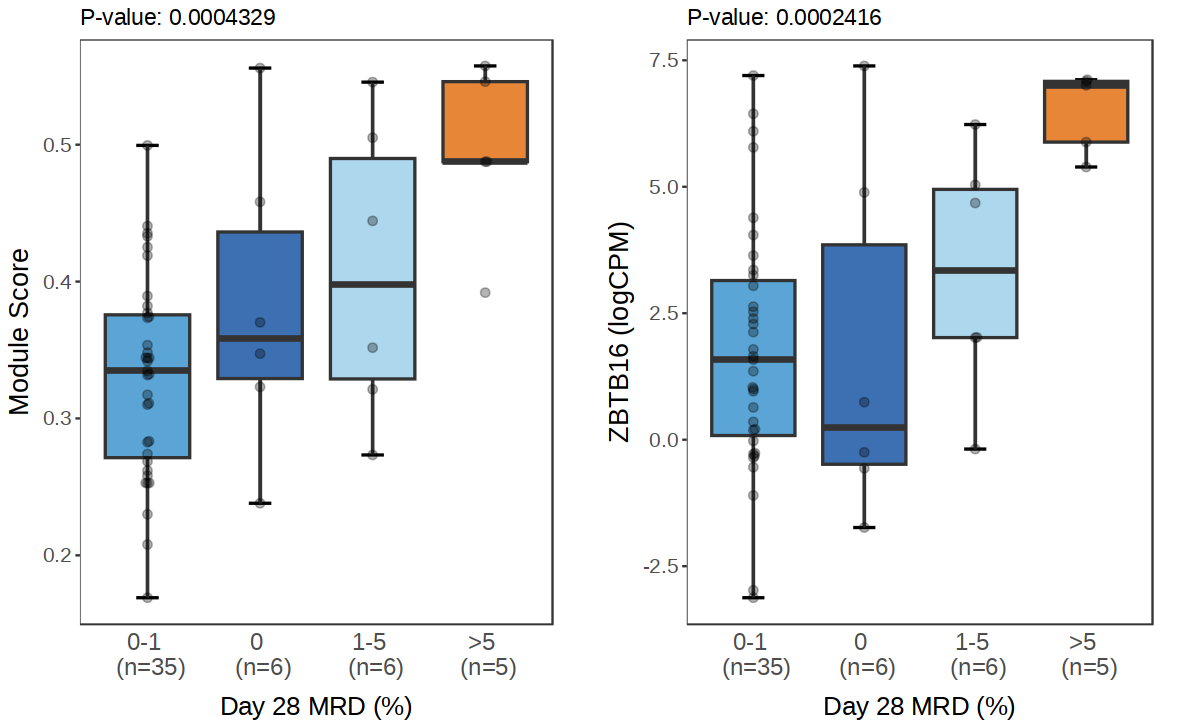

In [7]:
fig(10, 6)
cowplot::plot_grid(MRD_boxes[[1]]+ggtitle(paste0("P-value: ", p_1)),
                   MRD_boxes[[2]]+ggtitle(paste0("P-value: ", p_2)),
                   nrow=1)

<br>

<br>

## Figure 2C, 2E, & 2F

Boxplots for COG cohort

In [9]:
load(file=paste0(save_dir, "COG_dge.Rdata"))

In [10]:
## -- Group MRD
COG_dge$samples$MRD_group <- ifelse(COG_dge$samples$D29_MRD>=5,">5","1-5")
COG_dge$samples$MRD_group <- replace(COG_dge$samples$MRD_group, 
                                         (COG_dge$samples$D29_MRD>0) & (COG_dge$samples$D29_MRD<1), "0-1")
COG_dge$samples$MRD_group <- replace(COG_dge$samples$MRD_group,  COG_dge$samples$D29_MRD==0, "0")

In [11]:
## -- Plot boxplots
MRD_boxes <- plot_boxes_swarm_fill(COG_dge$samples[!(is.na(COG_dge$samples$MRD_group)),], "MRD_group", "EOI MRD (%)", "logTPM", mrd_cols ,cex_x=0.4, alpha_x=0.3, size_x=2)

## -- add P-values
p_1 <- getPval(COG_dge$samples[!(is.na(COG_dge$samples$MRD_group)),], "MRD_group", c(">5"), c("0", "0-1", "1-5"), "Module_score_up", sig_x=4)
p_2 <- getPval(COG_dge$samples[!(is.na(COG_dge$samples$MRD_group)),], "MRD_group", c(">5"), c("0", "0-1", "1-5"), "ZBTB16_exprs", sig_x=4)

Warning message in stat_boxplot(geom = "errorbar", width = 0.2, linewidth = 0.7, :
“Ignoring unknown aesthetics: fill”
Warning message in stat_boxplot(geom = "errorbar", width = 0.2, linewidth = 0.7, :
“Ignoring unknown aesthetics: fill”


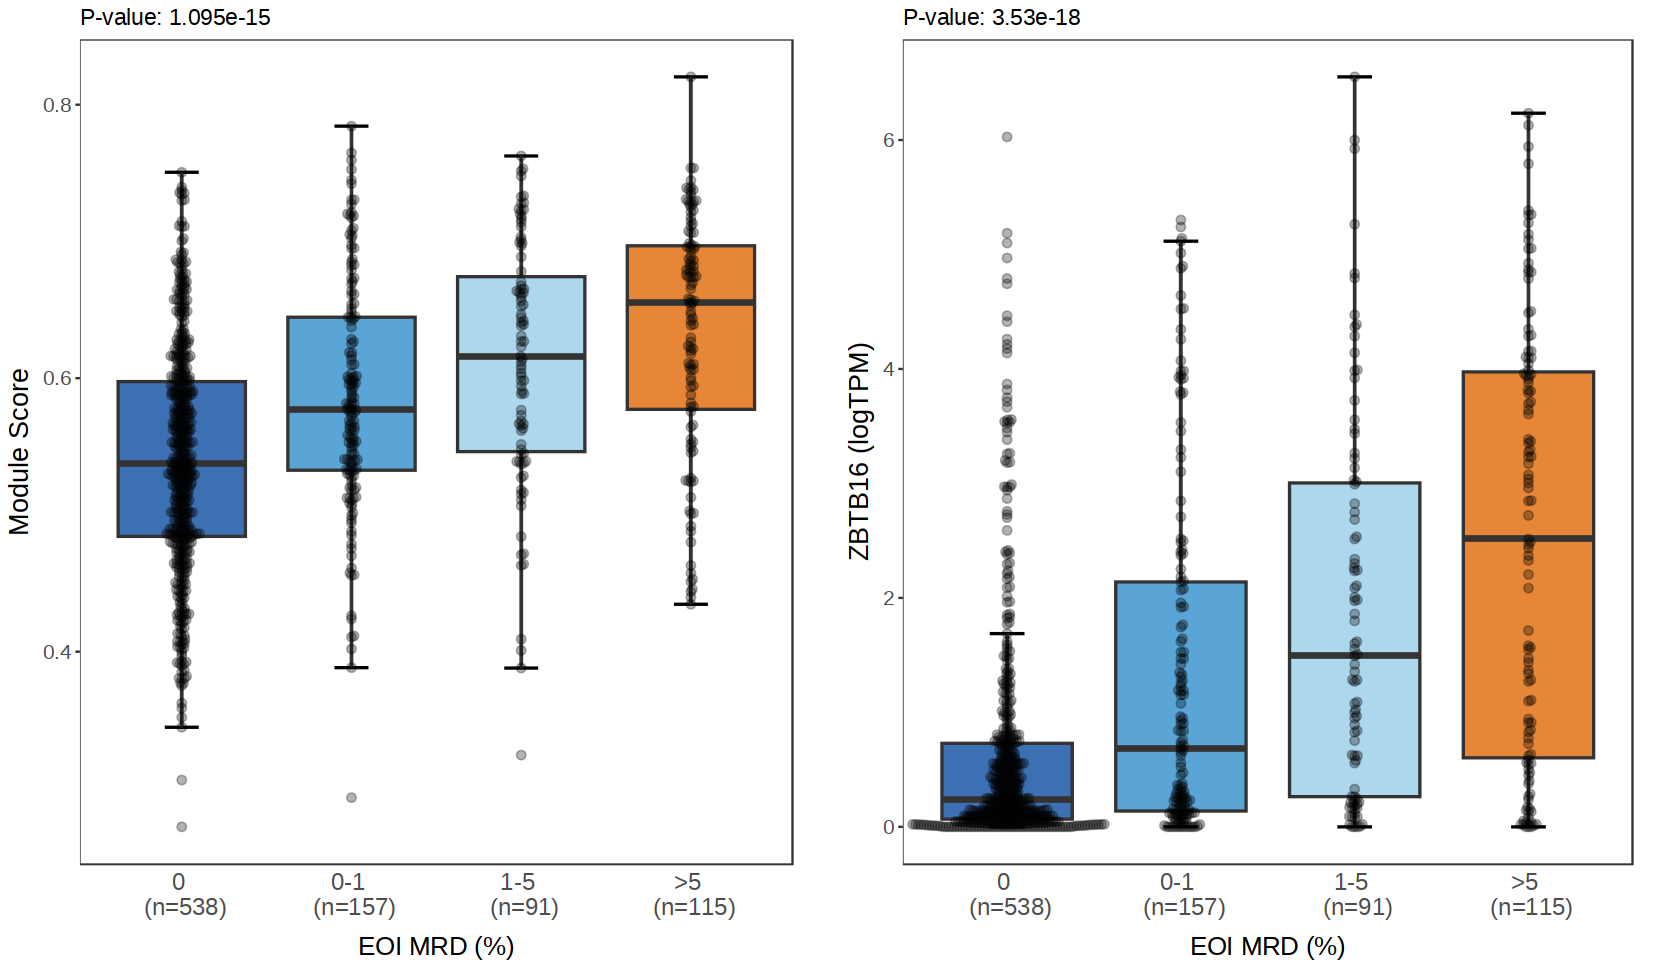

In [12]:
fig(14, 8)
cowplot::plot_grid(MRD_boxes[[1]]+ggtitle(paste0("P-value: ", p_1)),
                   MRD_boxes[[2]]+ggtitle(paste0("P-value: ", p_2)),
                   nrow=1)

<br>

### Plot immunophenotypic ETP

In [13]:
## -- Get ETP group
COG_dge$samples$ETP_IF <- ifelse((COG_dge$samples$ETP.STATUS=="ETP")&(COG_dge$samples$D29_MRD>=5),"ETP - IF","NA")
COG_dge$samples$ETP_IF <- replace(COG_dge$samples$ETP_IF,
                                     (COG_dge$samples$ETP.STATUS=="Non-ETP")&(COG_dge$samples$D29_MRD>=5), "Non-ETP - IF")
COG_dge$samples$ETP_IF <- replace(COG_dge$samples$ETP_IF,
                                     (COG_dge$samples$ETP.STATUS=="Non-ETP")&(COG_dge$samples$D29_MRD<5), "Non-ETP - Res")
COG_dge$samples$ETP_IF <- replace(COG_dge$samples$ETP_IF,
                                     (COG_dge$samples$ETP.STATUS=="ETP")&(COG_dge$samples$D29_MRD<5), "ETP - Res")

COG_dge$samples$ETP_IF <- replace(COG_dge$samples$ETP_IF,
                                     (COG_dge$samples$ETP.STATUS=="Near-ETP")&(COG_dge$samples$D29_MRD>=5), "Near-ETP - IF")
COG_dge$samples$ETP_IF <- replace(COG_dge$samples$ETP_IF,
                                     (COG_dge$samples$ETP.STATUS=="Near-ETP")&(COG_dge$samples$D29_MRD<5), "Near-ETP - Res")

COG_dge$samples$IF <- ifelse(COG_dge$samples$D29_MRD>=5, "IF", "Responsive")

#### Calculate P-values

In [14]:
dat_x <- COG_dge$samples[!(COG_dge$samples$ETP_IF=="NA"),]

for (i_str in c("Module_score_up","ZBTB16_exprs")){
    for (j_str in c('Non-ETP','Near-ETP','ETP')){
        X <- dat_x[(dat_x$ETP.STATUS==j_str & (dat_x$IF=="IF")), ][[i_str]]
        Y <- dat_x[(dat_x$ETP.STATUS==j_str & (dat_x$IF=="Responsive")), ][[i_str]]
        X <- X[!(is.na(X))]
        Y <- Y[!(is.na(Y))]
        p_val_x <- signif(wilcox.test(X,Y,alternative="greater")$p.value,4)
        print(paste0(j_str, " vs ",i_str,": ",p_val_x, " | lengths = ",length(X)," & ",length(Y)))
    }

}

[1] "Non-ETP vs Module_score_up: 7.894e-06 | lengths = 42 & 595"
[1] "Near-ETP vs Module_score_up: 1.093e-05 | lengths = 33 & 85"
[1] "ETP vs Module_score_up: 0.09837 | lengths = 26 & 45"
[1] "Non-ETP vs ZBTB16_exprs: 3.718e-05 | lengths = 42 & 595"
[1] "Near-ETP vs ZBTB16_exprs: 3.891e-07 | lengths = 33 & 85"
[1] "ETP vs ZBTB16_exprs: 0.002802 | lengths = 26 & 45"


#### Plot

In [15]:
tab_x <- table(dat_x$ETP_IF)

In [16]:
gg_1 <- ggplot(data=dat_x, aes(x=reorder(ETP_IF, ETP.STATUS), y=Module_score_up, fill=IF), colour="black")+
        stat_boxplot(geom = "errorbar", width = 0.2,linewidth=0.7)+
        geom_boxplot(outlier.shape = NA,linewidth=0.7)+
        theme_bw()+labs(x="", y="Module Score", fill="")+ scale_fill_manual(values=if_cols)+
        theme(axis.title.y=element_text(size=16, margin=margin(0,5,0,0)),
              axis.title.x=element_text(size=15, margin=margin(10,0,0,0)), 
              axis.text.y=element_text(size=12),axis.text.x=element_text(size=10, angle=90, hjust=1, vjust=0.5),
              panel.grid.major.x=element_blank(), panel.grid.major.y=element_blank(), panel.grid.minor.y=element_blank(),
              legend.position="right", legend.text=element_text(size=12), legend.title=element_text(size=12),
              plot.margin = unit(c(0.2, 1, 0, 0.2), "cm"),
              axis.ticks.x=element_blank())+
                    scale_x_discrete(breaks = names(tab_x),
                     labels = unlist(lapply(names(tab_x), function(x){paste0(x," (n=",tab_x[[x]],")") })))

In [17]:
gg_2 <- ggplot(data=dat_x, aes(x=reorder(ETP_IF, ETP.STATUS), y=ZBTB16_exprs, fill=IF), colour="black")+
        stat_boxplot(geom = "errorbar", width = 0.2,linewidth=0.7)+
        geom_boxplot(outlier.shape = NA,linewidth=0.7)+
        theme_bw()+labs(x="", y="ZBTB16 (logTPM)", fill="")+  scale_fill_manual(values=if_cols)+
        theme(axis.title.y=element_text(size=16, margin=margin(0,5,0,0)),
              axis.title.x=element_text(size=15, margin=margin(10,0,0,0)), 
              axis.text.y=element_text(size=12),axis.text.x=element_text(size=10, angle=90, hjust=1, vjust=0.5),
              panel.grid.major.x=element_blank(), panel.grid.major.y=element_blank(), panel.grid.minor.y=element_blank(),
              legend.position="right", legend.text=element_text(size=12), legend.title=element_text(size=12),
              plot.margin = unit(c(0.2, 1, 0, 0.2), "cm"),
              axis.ticks.x=element_blank()) + 
            scale_x_discrete(breaks = names(tab_x),
                     labels = unlist(lapply(names(tab_x), function(x){paste0(x," (n=",tab_x[[x]],")") })))

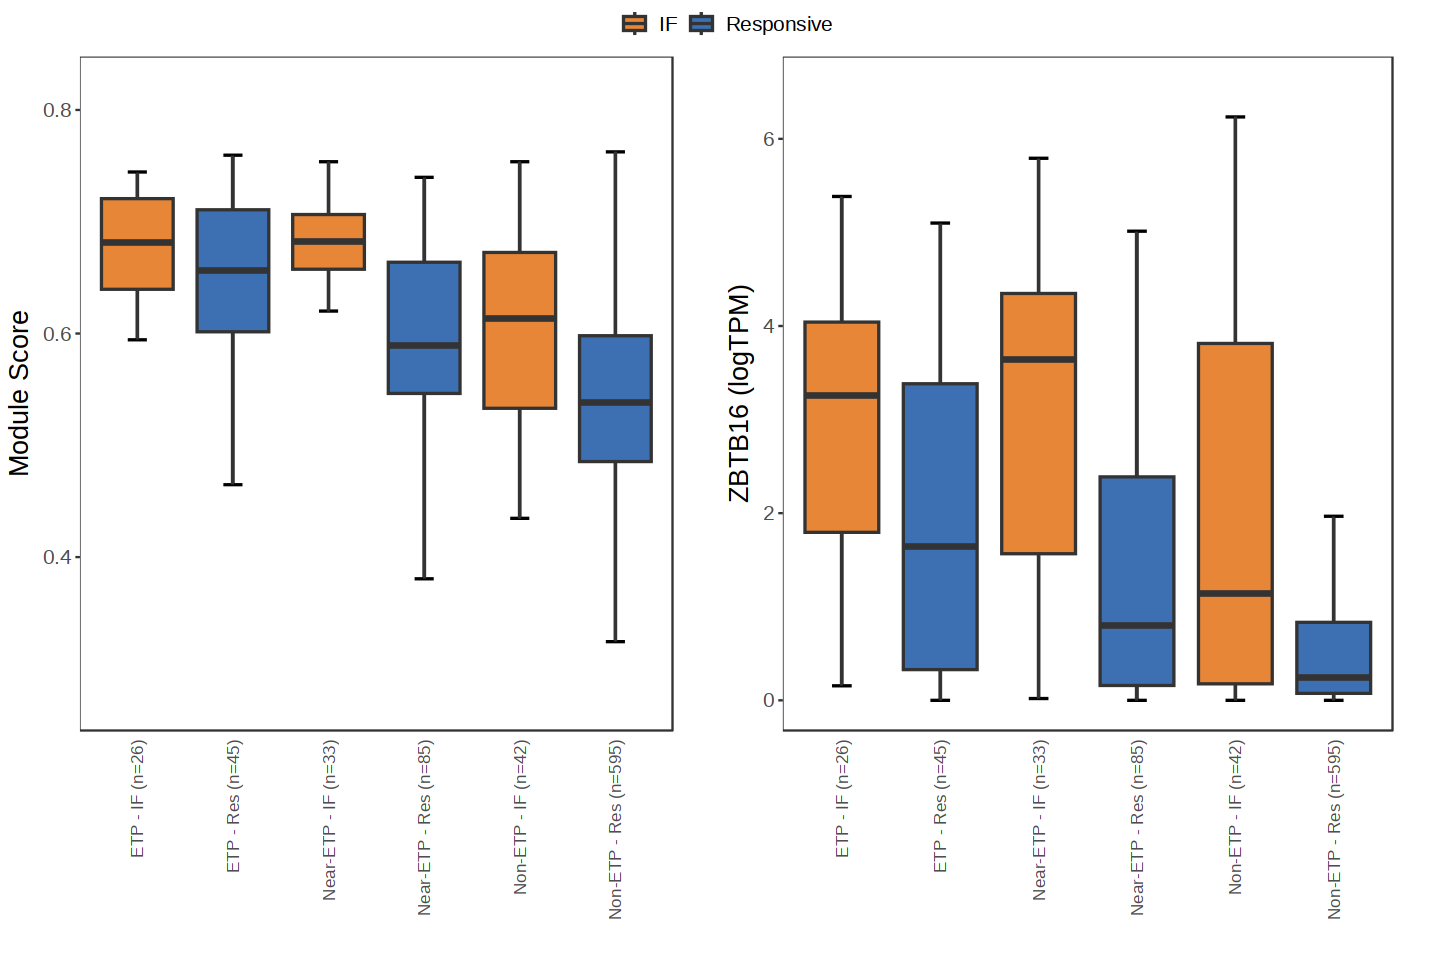

In [19]:
fig(12,8)
suppressWarnings(ggarrange(suppressMessages(gg_1), suppressMessages(gg_2), common.legend=TRUE))

<br>

### Plot transcriptional ETP subtype

In [46]:
## -- Make plotting dataframe
COG_dge$samples$ETPlike <- ifelse(COG_dge$samples$Reviewed.subtype=="ETP-like", "ETP-like", "Other")
COG_dge$samples$Group <- COG_dge$samples$ETPlike
dat_y <- COG_dge$samples[,colnames(COG_dge$samples) %in% c("Group","ZBTB16_exprs","ETP.STATUS","IF","Module_score_up")]
dat_y$ETP.STATUS <- ifelse(dat_y$Group=="ETP-like", "ETP-like", "Non-ETP")
dat_y <- dat_y[!(is.na(dat_y$IF)),]
dat_y$Group <- paste0(dat_y$Group, " - ", gsub("ponsive", "",dat_y$IF))



tab_x <- table(dat_y$Group)


In [47]:
gg_1 <- ggplot(data=dat_y, aes(x=reorder(Group, ETP.STATUS), y=Module_score_up, fill=IF), colour="black")+ #fill=ETP.STATUS
        stat_boxplot(geom = "errorbar", width = 0.2,linewidth=0.7)+
        geom_boxplot(outlier.shape = NA,linewidth=0.7, width=0.8)+ 
        theme_bw()+labs(x="", y="Module Score", fill="", colour="")+ 
        scale_fill_manual(values=if_cols)+
        theme(axis.title.y=element_text(size=16, margin=margin(0,5,0,0)),
              axis.title.x=element_text(size=15, margin=margin(10,0,0,0)), 
              axis.text.y=element_text(size=12),axis.text.x=element_text(size=10),
              panel.grid.major.x=element_blank(), panel.grid.major.y=element_blank(), panel.grid.minor.y=element_blank(),
              legend.position="none", legend.text=element_text(size=12), legend.title=element_text(size=12),
              plot.margin = unit(c(0.2, 1, 0, 0.2), "cm"),strip.background = element_blank(),
              strip.text.x=element_text(size=14),
              axis.ticks.x=element_blank())+
                    scale_x_discrete(breaks = names(tab_x),
                     labels = unlist(lapply(names(tab_x), function(x){paste0(lazySplit(x, " - ",1)," \n (n=",tab_x[[x]],")") })))

gg_2 <- ggplot(data=dat_y, aes(x=reorder(Group, ETP.STATUS), y=ZBTB16_exprs, fill=IF), colour="black")+ 
        stat_boxplot(geom = "errorbar", width = 0.2,linewidth=0.7)+
        geom_boxplot(outlier.shape = NA,linewidth=0.7, width=0.8)+
        theme_bw()+labs(x="", y="ZBTB16 (logTPM)", fill="", colour="")+ 
        scale_fill_manual(values=if_cols)+
        theme(axis.title.y=element_text(size=16, margin=margin(0,5,0,0)),
              axis.title.x=element_text(size=15, margin=margin(10,0,0,0)), 
              axis.text.y=element_text(size=12),axis.text.x=element_text(size=10), 
              panel.grid.major.x=element_blank(), panel.grid.major.y=element_blank(), panel.grid.minor.y=element_blank(),
              legend.position="none", legend.text=element_text(size=12), legend.title=element_text(size=12),
              plot.margin = unit(c(0.2, 1, 0, 0.55), "cm"),strip.background = element_blank(),
              strip.text.x=element_text(size=14),
              axis.ticks.x=element_blank()) + 
            scale_x_discrete(breaks = names(tab_x),
                     labels = unlist(lapply(names(tab_x), function(x){paste0(lazySplit(x, " - ",1)," \n (n=",tab_x[[x]],")") })))

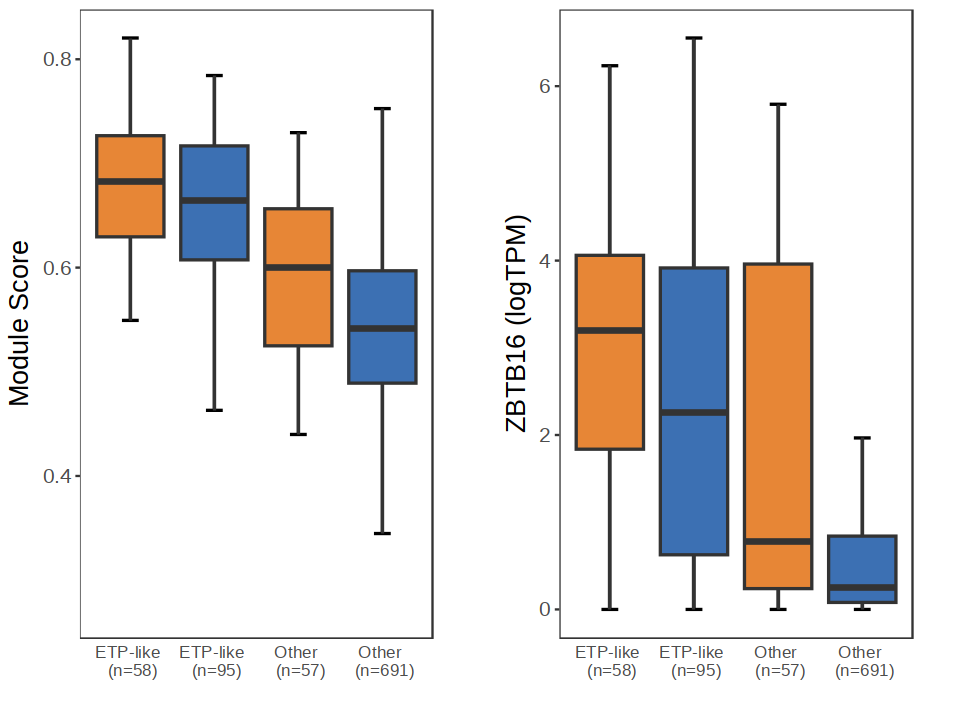

In [48]:
fig(8, 6)
suppressWarnings(ggarrange(suppressMessages(gg_1), suppressMessages(gg_2), nrow=1))

<br>

<br>

## COG survival analysis

In [35]:
COG_dge$samples$EFS.status <- as.character(COG_dge$samples$EFS.status)
COG_dge$samples$DFS.status <- as.character(COG_dge$samples$DFS.status)


In [47]:
### --- Functions

cutquantile = 0.3


runSurvivalAnalysis <- function(cdata_x, cluster, event_str){
    
    ## -- Check values
    if (length(cdata_x[which((cdata_x[, event_str] < 0) == TRUE), 
                   "short_name"]) > 0 ){
        print("Some patients have negative values for event")
    }
    
    ## -- Create into survival data structure
    cdata_x$s = grepl("1", cdata_x$OS.status, ignore.case = TRUE)
    cdata_x$cluster = as.factor(cluster)
    cdata_x$event <- as.vector(cdata_x[[event_str]])
    cdata_x = cdata_x[, c("event", "s", "cluster")]
    
    ## -- Set formula
    f = as.formula("Surv(event, s) ~ cluster")
    #f = as.formula("Surv(event) ~ cluster")
    sfit = do.call(survival::survfit, list(formula = f, data = cdata_x))
    
    ## -- Build DF
    strata = sfit$strata
    names(strata) = gsub('cluster=', '', names(strata))

    strata = rep(names(strata), times = strata)
    plotdf = data.frame(
        'Time' = sfit$time,
        'surv' = sfit$surv,
        'Event' = sfit$n.censor,
        'lower' = sfit$lower,
        'upper' = sfit$upper,
        'Group' = strata,
        'p' = surv_pvalue(sfit, data = cdata_x)$pval,
        'p_txt' = surv_pvalue(sfit, data = cdata_x)$pval.txt
    )
    #plotdf = plotdf[!is.na(plotdf$lower), ]
    #stopifnot(all(table(plotdf$Group) > 1))
    
    survdfs = list(T_ALL=plotdf)
    survdfs = survdfs[!is.na(survdfs)]
    
    ## -- Return
    return(survdfs)
    
}

runSurvivalAnalysis_EFS <- function(cdata_x, cluster, event_str, status_str){
    
    ## -- Check values
    if (length(cdata_x[which((cdata_x[, event_str] < 0) == TRUE), 
                   "short_name"]) > 0 ){
        print("Some patients have negative values for event")
    }
    
    ## -- Create into survival data structure
    cdata_x$s = grepl("1", cdata_x[[status_str]], ignore.case = TRUE)
    cdata_x$cluster = as.factor(cluster)
    cdata_x$event <- as.vector(cdata_x[[event_str]])
    cdata_x = cdata_x[, c("event", "s", "cluster")]
    
    ## -- Set formula
    f = as.formula("Surv(event, s) ~ cluster")
    #f = as.formula("Surv(event) ~ cluster")
    sfit = do.call(survival::survfit, list(formula = f, data = cdata_x))
    
    ## -- Build DF
    strata = sfit$strata
    names(strata) = gsub('cluster=', '', names(strata))

    strata = rep(names(strata), times = strata)
    plotdf = data.frame(
        'Time' = sfit$time,
        'surv' = sfit$surv,
        'Event' = sfit$n.censor,
        'lower' = sfit$lower,
        'upper' = sfit$upper,
        'Group' = strata,
        'p' = surv_pvalue(sfit, data = cdata_x)$pval,
        'p_txt' = surv_pvalue(sfit, data = cdata_x)$pval.txt
    )
    #plotdf = plotdf[!is.na(plotdf$lower), ]
    #stopifnot(all(table(plotdf$Group) > 1))
    
    survdfs = list(T_ALL=plotdf)
    survdfs = survdfs[!is.na(survdfs)]
    
    ## -- Return
    return(survdfs)
    
}

plotGDCSurvival_hjw <- function(survdf_list,n_row=1, str="ModuleScore"){

  plotdf = ldply(survdf_list, .id = 'Project')
  
  #order by pvals
  pvaldf = base::unique(plotdf[, c('Project', 'p')])
  plotdf$Project = factor(plotdf$Project, pvaldf$Project[order(pvaldf$p)])
  
  #add counts
  plotdf = ddply(plotdf, 'Group', function (x) {
    x$Group = paste0(x$Group,' (n=', nrow(x), ')') # paste0(x$Group, ' ~ ', str,' (n=', nrow(x), ')')
    return(x)
  })
  
  #pvalue annotations
  annotdf = base::unique(plotdf[, c('Project', 'p_txt')])
  annotdf$Group = plotdf$Group[1]
  
  p1 = ggplot(plotdf, aes(Time, surv, colour = Group, fill = Group)) +
    geom_ribbon(
      aes(ymin = lower, ymax = upper),
      colour = NA,
      alpha = 0.25,
      stat = 'stepribbon',
      show.legend = FALSE
    ) +
    geom_step(show.legend = FALSE) +
    geom_point(data = plotdf[plotdf$Event != 0, ],
               shape = '+',
               size = 5) +
    geom_text(
      aes(x = -Inf, y = -Inf, label = p_txt),
      hjust = -0.1,
      vjust = -1,
      colour = 'black',
      data = annotdf,
      show.legend = FALSE
    ) +
    facet_wrap(~ Project, scales = 'free_x',nrow=n_row) +
    xlab('Time (Days)') +
    scale_y_continuous(limits = c(0, 1),
                       name = 'Survival probability',
                       breaks = c(0,  1),
                       expand=c(0,0)) +
    scale_x_continuous(expand=c(0,0)) +
    scale_colour_manual(
     # palette ='Set2',#'Set2',
      values=c("#237186", "#8E1F43"),
      aesthetics = c('colour', 'fill'),
      # label = function(breaks) {parse(text = breaks)},
      guide = guide_legend(
        override.aes = list(shape = 19, size=4),
        ncol = 2,
        title = '',
        label.theme =element_text(size=8)
      )
    ) +
    guides(fill = guide_none()) + theme_bw() +
    theme(legend.position = 'bottom', axis.text=element_text(size=12),axis.title=element_text(size=16), 
          panel.grid.major.x=element_blank(), panel.grid.major.y=element_blank(), panel.grid.minor.y=element_blank(), panel.grid.minor.x=element_blank(),
          legend.text=element_text(size=14), strip.background = element_blank(),strip.text.x=element_text(size=18))
  return(p1)
}


### Split data

In [48]:
## -- stratify based on singscore
svec <- COG_dge$samples$Module_score_up

scstrata = rep(NA, length(svec))
scstrata[svec < quantile(svec, cutquantile)] = 'Score-low'
scstrata[svec > quantile(svec, 1 - cutquantile)] = 'Score-high'

names(scstrata) <- rownames(COG_dge$samples)

## -- stratify based on ZBTB16
svec <- COG_dge$samples$ZBTB16_exprs

scstrata_Z = rep(NA, length(svec))
scstrata_Z[svec < quantile(svec, cutquantile)] = 'ZBT16-low'
scstrata_Z[svec > quantile(svec, 1 - cutquantile)] = 'ZBT16-high'

names(scstrata_Z) <- rownames(COG_dge$samples)


### Calculate KM

In [52]:
## -- Calc KM for OS
survdfs_os = runSurvivalAnalysis(COG_dge$samples,scstrata, "OS")
survdfs_Z = runSurvivalAnalysis(COG_dge$samples,scstrata_Z, "OS")

names(survdfs_os) = "OS - Split by module score"
names(survdfs_Z) = "OS - Split by ZBTB16 expression"

## -- Calc KM for EFS
survdfs_efs = runSurvivalAnalysis_EFS(COG_dge$samples,scstrata, "EFS", "EFS.status")
survdfs_Z_efs = runSurvivalAnalysis_EFS(COG_dge$samples,scstrata_Z, "EFS", "EFS.status")

names(survdfs_efs) = "EFS - Split by module score"
names(survdfs_Z_efs) = "EFS - Split by ZBTB16 expression"

### Plot OFS

In [50]:
p1 <- plotGDCSurvival_hjw(survdfs_os,n_row=1)
p2 <- plotGDCSurvival_hjw(survdfs_Z,n_row=1, str= "logTPM")

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


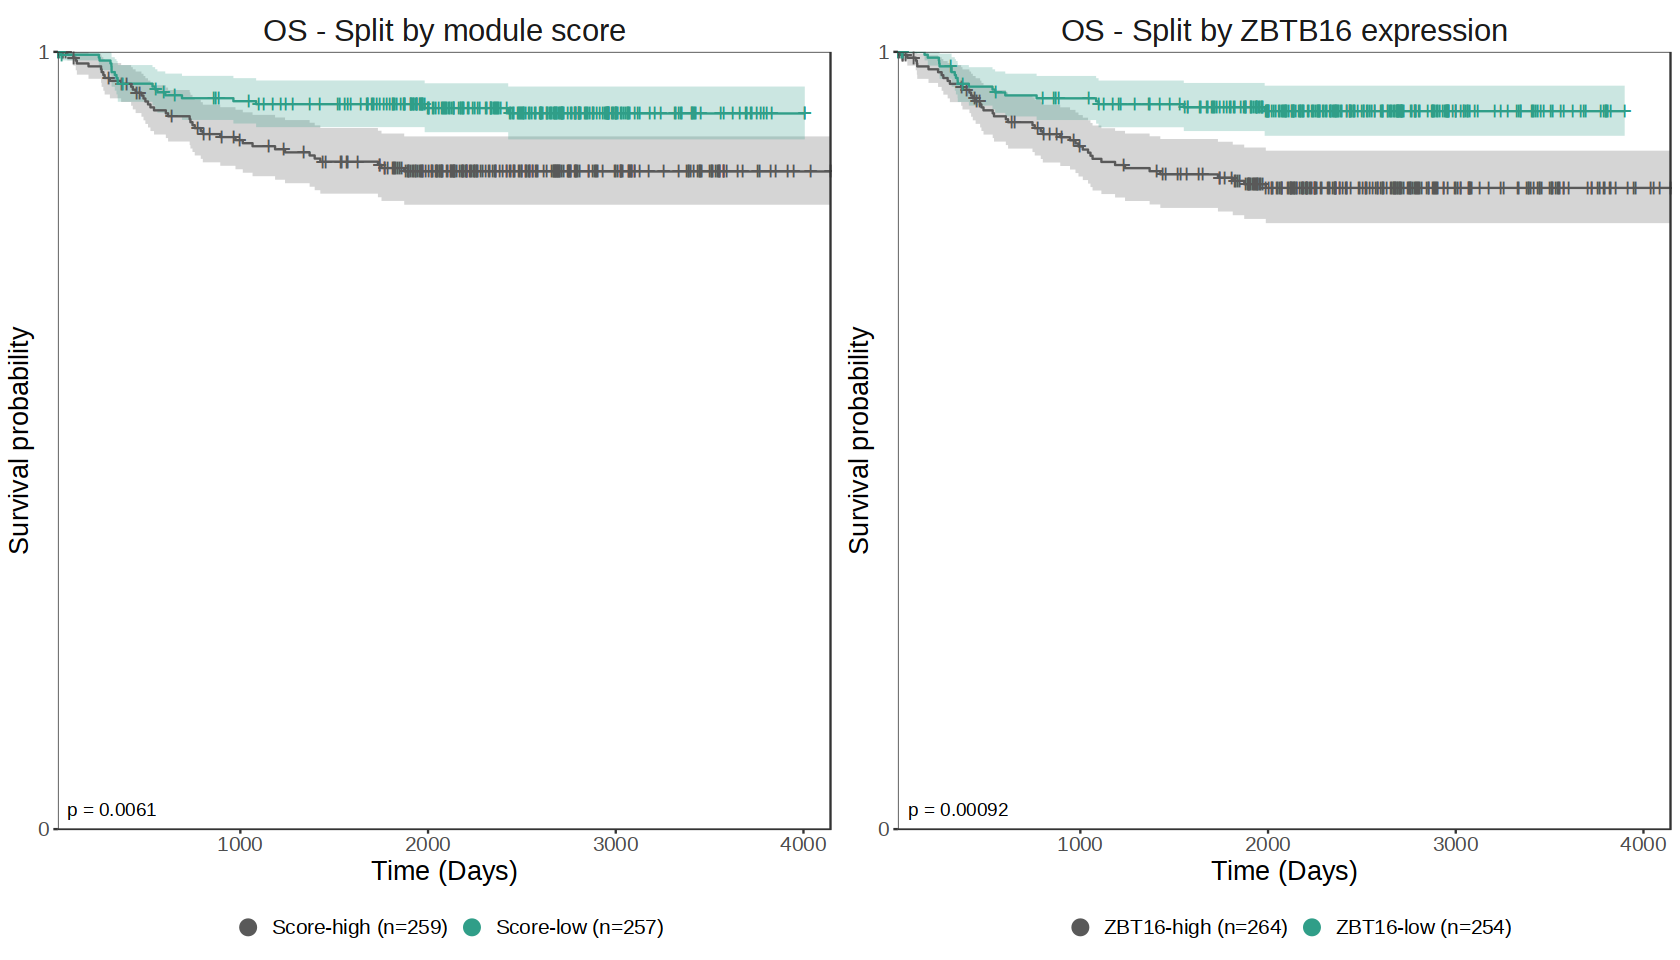

In [51]:
cowplot::plot_grid(p1+scale_colour_manual(values=c("#595959", "#309E88"), aesthetics = c('colour', 'fill'),
                                         guide = guide_legend(override.aes = list(shape = 19, size=4),
                                                 ncol = 2,title = '',label.theme =element_text(size=12))),
                   p2+scale_colour_manual(values=c("#595959", "#309E88"), aesthetics = c('colour', 'fill'),
                                         guide = guide_legend(override.aes = list(shape = 19, size=4),
                                                 ncol = 2,title = '',label.theme =element_text(size=12))),
                   ncol=2)

### Plot EFS

In [54]:
p3 <- plotGDCSurvival_hjw(survdfs_efs,n_row=1)
p4 <- plotGDCSurvival_hjw(survdfs_Z_efs,n_row=1, str= "logTPM")

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


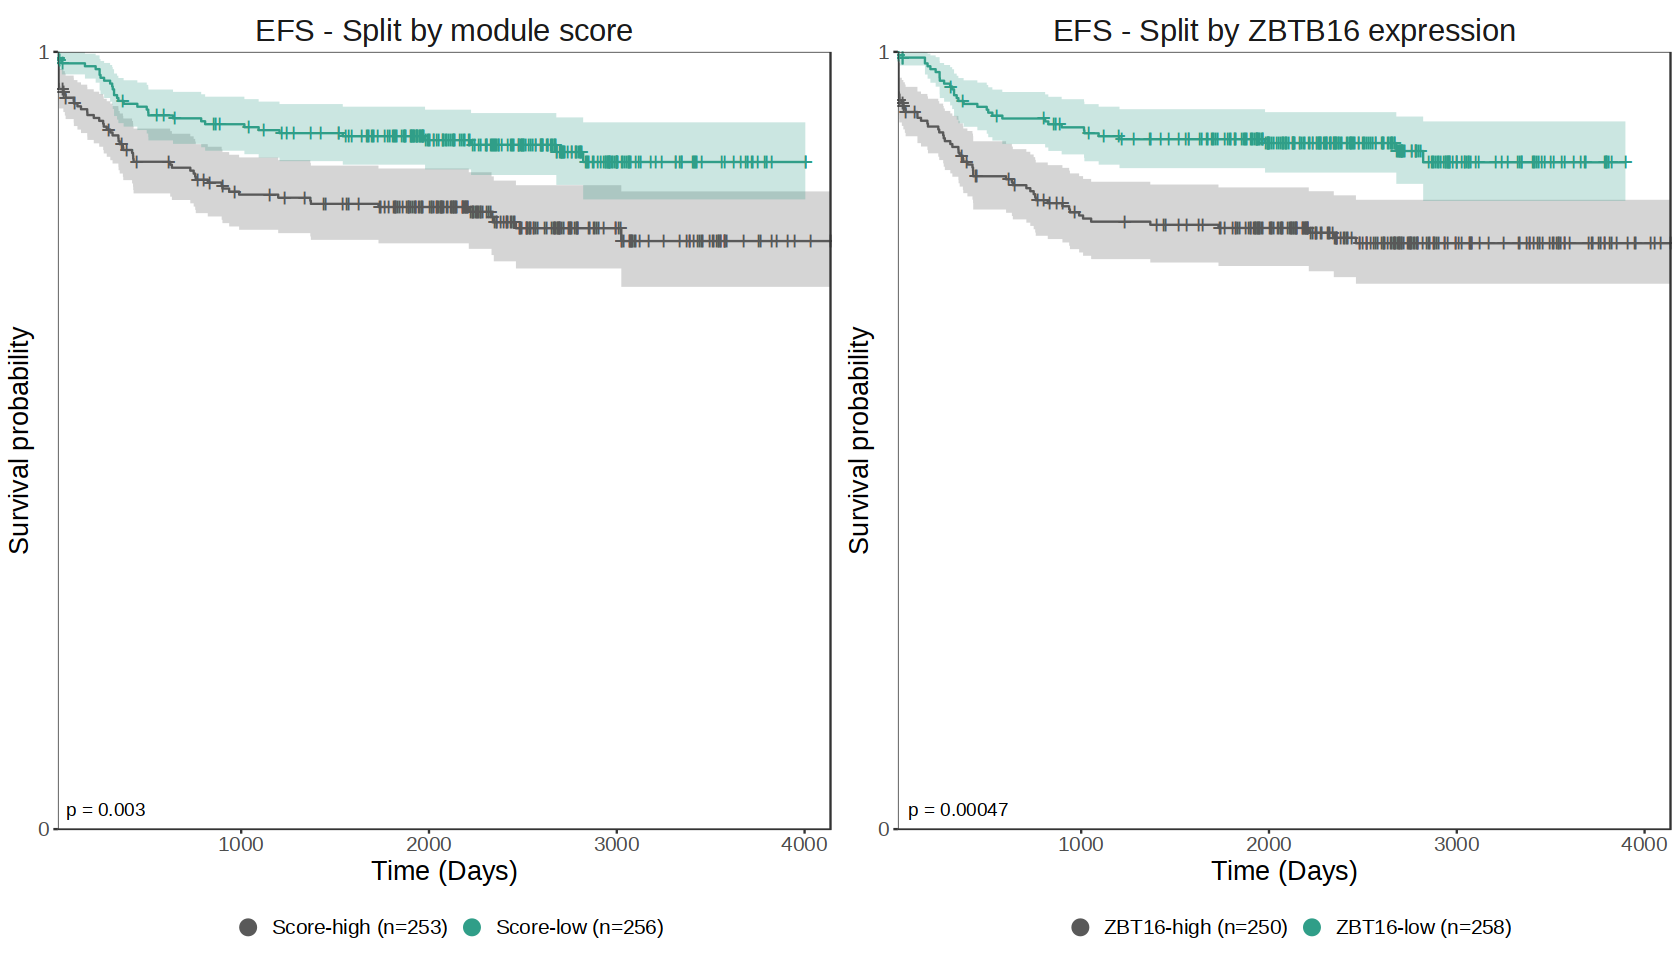

In [55]:
cowplot::plot_grid(p3+scale_colour_manual(values=c("#595959", "#309E88"), aesthetics = c('colour', 'fill'),
                                         guide = guide_legend(override.aes = list(shape = 19, size=4),
                                                 ncol = 2,title = '',label.theme =element_text(size=12))),
                   p4+scale_colour_manual(values=c("#595959", "#309E88"), aesthetics = c('colour', 'fill'),
                                         guide = guide_legend(override.aes = list(shape = 19, size=4),
                                                 ncol = 2,title = '',label.theme =element_text(size=12))),
                   ncol=2)